In [ ]:
dataZipPath = '/content/drive/MyDrive/TopTal/temples-train-hard.zip'

!unzip -n $dataZipPath -d \data

Archive:  /content/drive/MyDrive/TopTal/temples-train-hard.zip
   creating: data/train/
   creating: data/train/Armenia/
  inflating: data/train/Armenia/Armenia_095.JPG  
  inflating: data/train/Armenia/Echmiadzin_005.JPG  
  inflating: data/train/Armenia/Echmiadzin_011.JPG  
  inflating: data/train/Armenia/Echmiadzin_026.JPG  
  inflating: data/train/Armenia/Echmiadzin_031.JPG  
  inflating: data/train/Armenia/Echmiadzin_033.JPG  
  inflating: data/train/Armenia/Garni_009.JPG  
  inflating: data/train/Armenia/Garni_012.JPG  
  inflating: data/train/Armenia/Garni_023.JPG  
  inflating: data/train/Armenia/Yerevan_026.JPG  
  inflating: data/train/Armenia/Yerevan_031.JPG  
   creating: data/train/Australia/
  inflating: data/train/Australia/Adelaide_104.jpg  
  inflating: data/train/Australia/Adelaide_134.jpg  
  inflating: data/train/Australia/Adelaide_146.jpg  
  inflating: data/train/Australia/Adelaide_147.jpg  
  inflating: data/train/Australia/Adelaide_192.jpg  
  inflating: data/tr

In [ ]:
!du -sh \data

1020M	data


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.4 MB/s 


In [ ]:
#imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import glob
import PIL
import math
import tensorflow as tf
import tensorflow_addons as tfa

print(tf.__version__)

2.6.0


In [ ]:
# retrieve LABELS from data folders

DATA_ROOT_FOLDER = '/content/data'

LABELS = list(os.listdir(f"{DATA_ROOT_FOLDER}/train"))
LABELS

['Thailand',
 'Australia',
 'Indonesia-Bali',
 'Spain',
 'Portugal+Brazil',
 'Japan',
 'Germany',
 'Russia',
 'Malaysia+Indonesia',
 'Hungary+Slovakia+Croatia',
 'Armenia']

In [ ]:
# let's explore it a bit

imageSize = []
for label in LABELS:
  for imageFile in glob.glob(f'{DATA_ROOT_FOLDER}/train/{label}/*'):
    image = PIL.Image.open(imageFile)
    imageSize.append(image.size + (label, imageFile))

In [ ]:

imagesDf = pd.DataFrame(imageSize, columns=["width", "height", "label_name", "fileName"])

# add label encoding
imagesDf['label'] = imagesDf.apply(lambda row: LABELS.index(row.label_name), axis=1)

imagesDf.describe()

,width,height,label
count,714.000000,714.000000,714.000000
mean,3275.333333,2210.997199,4.700280
std,1109.866361,744.913909,2.896983
min,1200.000000,1200.000000,0.000000
25%,2592.000000,1728.000000,2.000000
50%,2592.000000,1728.000000,5.000000
75%,3861.000000,2574.000000,7.000000
max,5616.000000,4288.000000,10.000000


In [ ]:
imagesDf.head(100)

,width,height,label_name,fileName,label
0,2592,1728,Thailand,/content/data/train/Thailand/Songkhla_057.JPG,0
1,2592,1728,Thailand,/content/data/train/Thailand/Bangkok_337.JPG,0
2,2592,1728,Thailand,/content/data/train/Thailand/Chiang_Rai_011.JPG,0
3,3861,2574,Thailand,/content/data/train/Thailand/Bangkok_2019_132.jpg,0
4,2592,1728,Thailand,/content/data/train/Thailand/Phetchaburi_063.JPG,0
...,...,...,...,...,...
95,2592,1728,Thailand,/content/data/train/Thailand/Nong_Khai_078.JPG,0
96,2592,1728,Thailand,/content/data/train/Thailand/Chiang_Mai_073.JPG,0
97,3861,2574,Thailand,/content/data/train/Thailand/Bangkok_2019_222.jpg,0
98,2592,1728,Thailand,/content/data/train/Thailand/Phetchaburi_052.JPG,0


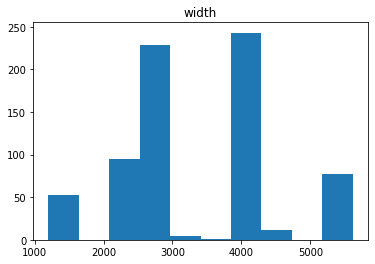

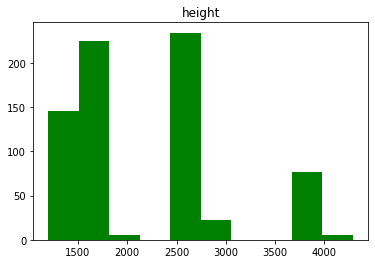

In [ ]:
plt.hist(imagesDf['width'])
plt.title('width')
plt.show()
plt.hist(imagesDf['height'], color='green')
plt.title('height')
plt.show()


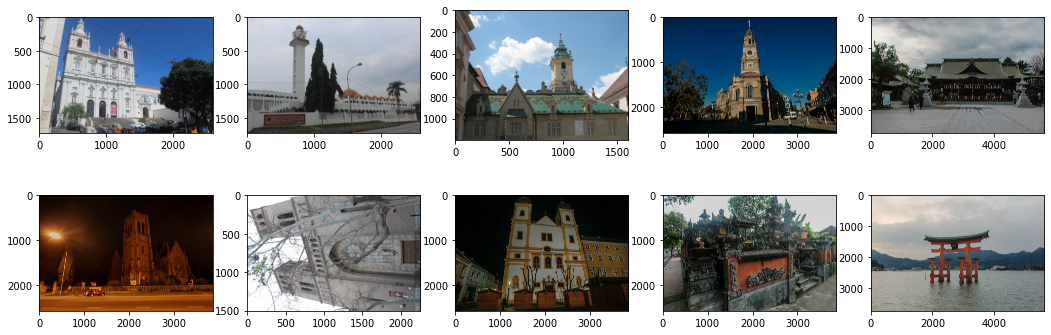

In [ ]:


f = plt.figure(figsize=(18, 6))
n, rows = (10, 2)
for idx in range(n):
  f.add_subplot(2, n / rows, idx + 1)
  plt.imshow(PIL.Image.open(imagesDf.iloc[random.randrange(imagesDf.shape[0])]["fileName"]))

In [ ]:
labelCount = imagesDf['label_name'].value_counts()
labelCount

Russia                      124
Germany                     107
Thailand                    104
Spain                        68
Japan                        62
Malaysia+Indonesia           55
Portugal+Brazil              54
Hungary+Slovakia+Croatia     49
Indonesia-Bali               45
Australia                    35
Armenia                      11
Name: label_name, dtype: int64

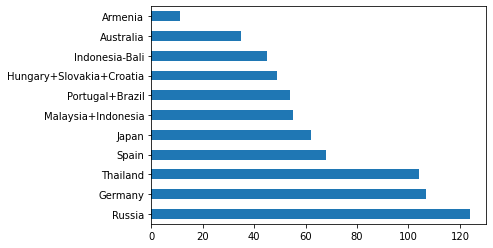

In [ ]:
labelCount.plot(kind='barh')

### Hyperparams


In [ ]:
INPUT_SIZE = (256, 256)

BS = 32
MODEL_SAVE_DIR = '/content/drive/MyDrive/TopTal/models'
FOLDS = 4


### Creating Datasets with augmentations

In [ ]:
# augmenter

import tensorflow.keras.backend as K
import math

SATURATION  = (0.2, 1.1)
CONTRAST = (0.5, 1.1)
BRIGHTNESS  =  0.1
ROTATION    = 180.0
SHEAR    = 1.0
HZOOM  = 8.0
WZOOM  = 4.0
HSHIFT = 50.0
WSHIFT = 50.0

@tf.function
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

@tf.function
def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = INPUT_SIZE[0]
    XDIM = DIM%2
    
    rot = ROTATION * tf.random.normal([1], dtype='float32')
    shr = SHEAR * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM
    h_shift = HSHIFT * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT * tf.random.normal([1], dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [ ]:


def build_decoder(with_labels=True, target_size=INPUT_SIZE, ext='jpg'):
    @tf.function
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    @tf.function
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, SATURATION[0], SATURATION[1])
        img = tf.image.random_contrast(img, CONTRAST[0], CONTRAST[1])
        img = tf.image.random_brightness(img, BRIGHTNESS)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,
                  seed=None, cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, tf.keras.utils.to_categorical(labels, num_classes=len(LABELS)))
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    
    # Map the functions to perform Augmentations
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(transform, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle, seed=seed) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset



In [ ]:
dataset = build_dataset(imagesDf['fileName'], imagesDf['label'], augment=True)  # cache_dir="data_cache/" # data can be cached on disk

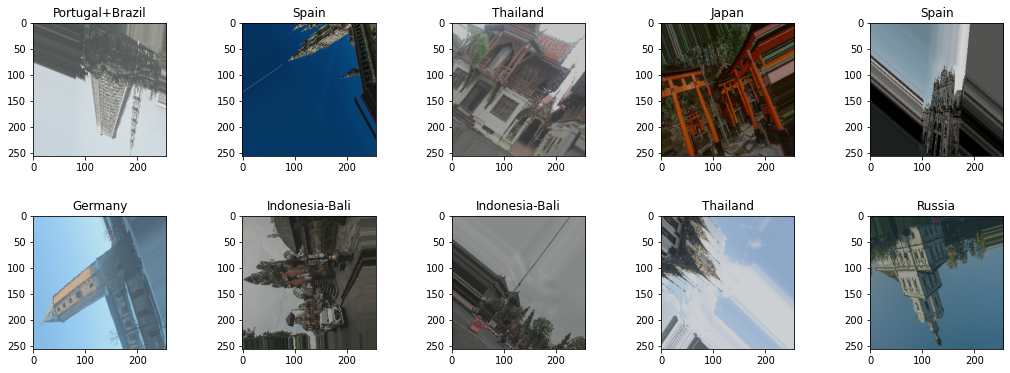

In [ ]:
def show_sample_ds(dataset):
  sample = iter(dataset.unbatch())

  f = plt.figure(figsize=(18, 6))
  f.subplots_adjust(wspace=.25, hspace=.45)
  n, rows = (10, 2)
  for idx in range(n):
    f.add_subplot(2, n / rows, idx + 1)
    img_label = next(sample)
    plt.imshow(img_label[0])
    plt.title(LABELS[np.argmax(img_label[1])])

show_sample_ds(dataset)
del dataset

In [ ]:
# re-balance label distribution

def rebalance_label_distribution(imagesDf):
  labelCount = imagesDf['label_name'].value_counts()
  max_count = max(labelCount)
  for count, label in zip(labelCount, labelCount.index):
    missing = max_count - count
    subset = imagesDf[imagesDf['label_name'] == label]
    subset = subset.sample(n = missing, replace=True)
    imagesDf = imagesDf.append(subset)

  imagesDf = imagesDf.sample(frac=1).reset_index(drop=True) 

  return imagesDf

def test_rebalance_label_distribution(imagesDf):
  labelCount = imagesDf['label_name'].value_counts()
  print(labelCount)
  imagesDf = rebalance_label_distribution(imagesDf)
  labelCount = imagesDf['label_name'].value_counts()
  print(labelCount)

#test_rebalance_label_distribution(imagesDf)

In [ ]:
# Saving models
# .h5 (single file)
# .tflite = tensorflow lite

def model_to_tflite(model_h5_name, output_name, with_optimizations=False):    
    model = tf.keras.models.load_model(model_h5_name)
    
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    if (with_optimizations is True):
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]

    tflite_model = converter.convert()

    # Save the model.
    with open(output_name, 'wb') as f:
      f.write(tflite_model)

    print(f"Model saved to '{output_name}' ")

def save_model (model, name, with_tf_lite=False, with_optimizations=False):
  os.makedirs(os.path.dirname(f"{name}.h5"), exist_ok = True)
  model.save(f"{name}.h5")

  if (with_tf_lite):
    model_to_tflite(f"{name}.h5",f"{name}.tflite", with_optimizations)

  print(f"Model saved to {f'{name}.h5'}")


In [ ]:
# Build model

import tensorflow_addons as tfa

def generate_model(input_shape, num_classes):

  dn = tf.keras.applications.densenet.DenseNet201 (
  # dn = tf.keras.applications.efficientnet.EfficientNetB4 (
                                            weights='imagenet', 
                                            include_top=False, 
                                            input_shape=input_shape,
                                            #classes=len(CLASSES)
                                            )
  dn.trainable = False # Full Training
  
  model = tf.keras.Sequential([
      dn,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(64, activation='swish'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(64, activation='swish'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(num_classes, activation='softmax'
                            #kernel_constraint=maxnorm(3)
                            )
  ])

  METRICS = [
    #tf.keras.metrics.TruePositives(name='tp'),
    #tf.keras.metrics.FalsePositives(name='fp'),
    #tf.keras.metrics.TrueNegatives(name='tn'),
    #tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc', num_labels=len(LABELS), multi_label=True, from_logits=False),
    tf.keras.metrics.AUC(name='prc', curve='PR', num_labels=len(LABELS), multi_label=True, from_logits=False), # precision-recall curve
    tfa.metrics.F1Score(name='f1_score', num_classes=num_classes, average='macro')
  ] 
          
  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, 
                                          beta_1=0.9, 
                                          beta_2=0.999, 
                                          epsilon=1e-07, 
                                          amsgrad=False),
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.05),
      metrics=METRICS
  )

  # print(model.summarry())

  return model


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
def display_training_curves(training, validation, modelname, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(16,8), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    
    if (validation is not None):
        ax.plot(validation)
        
    ax.set_title(modelname + " " + title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    

In [ ]:
# Model validation helpers

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS, fontdict={'fontsize': 9})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(LABELS)))
    ax.set_yticklabels(LABELS, fontdict={'fontsize': 9})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(len(LABELS) - 1, 0, titlestring, fontdict={'fontsize': 9, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()


def validate_model(model, val_dataset, model_name = ""):
  cm_probabilities = model.predict(val_dataset)
  cm_predictions = np.argmax(cm_probabilities, axis=-1)

  # cm_correct_labels = next(iter(val_dataset.batch(NUM_VALIDATION_IMAGES))).numpy()
  cm_correct_labels = np.concatenate([[np.argmax(y)] for x, y in val_dataset.unbatch()], axis=0)

  cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(LABELS)))

  score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(LABELS)), average='macro')
  precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(LABELS)), average='macro')
  recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(LABELS)), average='macro')
  #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
  display_confusion_matrix(cmat, score, precision, recall)
  print('{:} f1_score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(model_name, score, precision, recall))



Next fold: 1/4
Train set:
Russia                      93
Germany                     80
Thailand                    78
Spain                       51
Japan                       47
Malaysia+Indonesia          41
Portugal+Brazil             40
Hungary+Slovakia+Croatia    37
Indonesia-Bali              34
Australia                   26
Armenia                      8
Name: label_name, dtype: int64
Test set:
Russia                      31
Germany                     27
Thailand                    26
Spain                       17
Japan                       15
Malaysia+Indonesia          14
Portugal+Brazil             14
Hungary+Slovakia+Croatia    12
Indonesia-Bali              11
Australia                    9
Armenia                      3
Name: label_name, dtype: int64
Train set (re-balanced):
Armenia                     93
Germany                     93
Russia                      93
Japan                       93
Indonesia-Bali              93
Spain                       93
Malaysia+

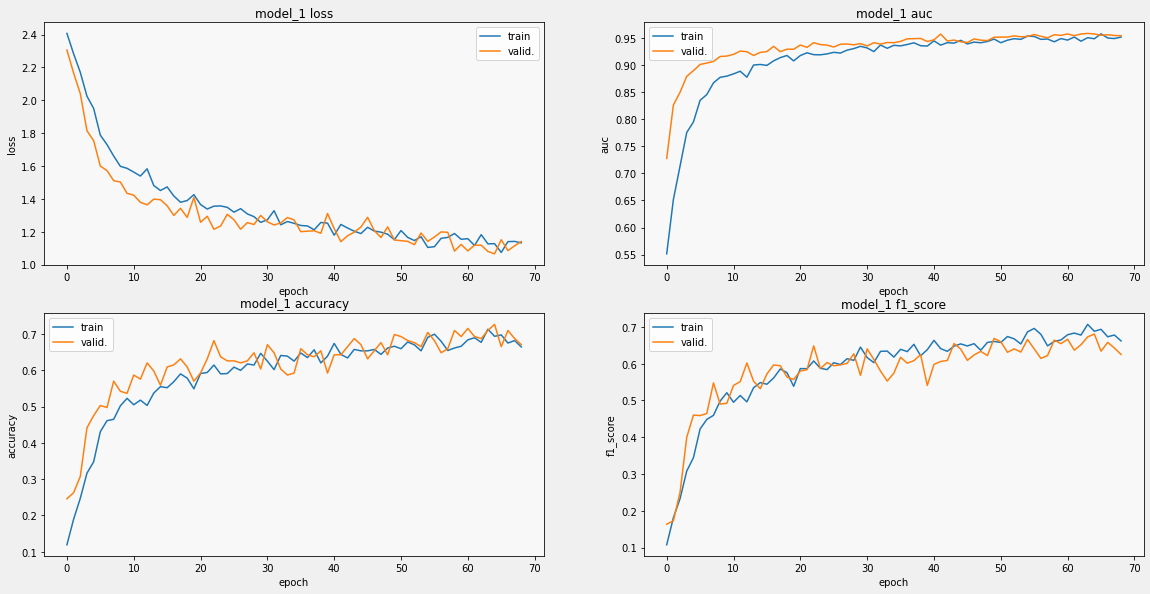

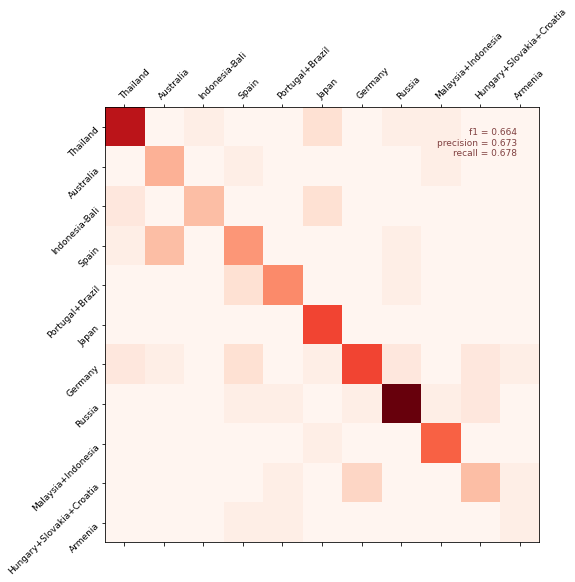

model_1 f1_score: 0.664, precision: 0.673, recall: 0.678
INFO:tensorflow:Assets written to: /tmp/tmp6nzh8thd/assets


INFO:tensorflow:Assets written to: /tmp/tmp6nzh8thd/assets


Model saved to /content/drive/MyDrive/TopTal/models/20210903_134046/model_1.h5  and /content/drive/MyDrive/TopTal/models/20210903_134046/model_1.tflite
Next fold: 2/4
Train set:
Russia                      93
Germany                     80
Thailand                    78
Spain                       51
Japan                       47
Malaysia+Indonesia          41
Portugal+Brazil             40
Hungary+Slovakia+Croatia    37
Indonesia-Bali              34
Australia                   26
Armenia                      8
Name: label_name, dtype: int64
Test set:
Russia                      31
Germany                     27
Thailand                    26
Spain                       17
Japan                       15
Malaysia+Indonesia          14
Portugal+Brazil             14
Hungary+Slovakia+Croatia    12
Indonesia-Bali              11
Australia                    9
Armenia                      3
Name: label_name, dtype: int64
Train set (re-balanced):
Armenia                     93
Germany     

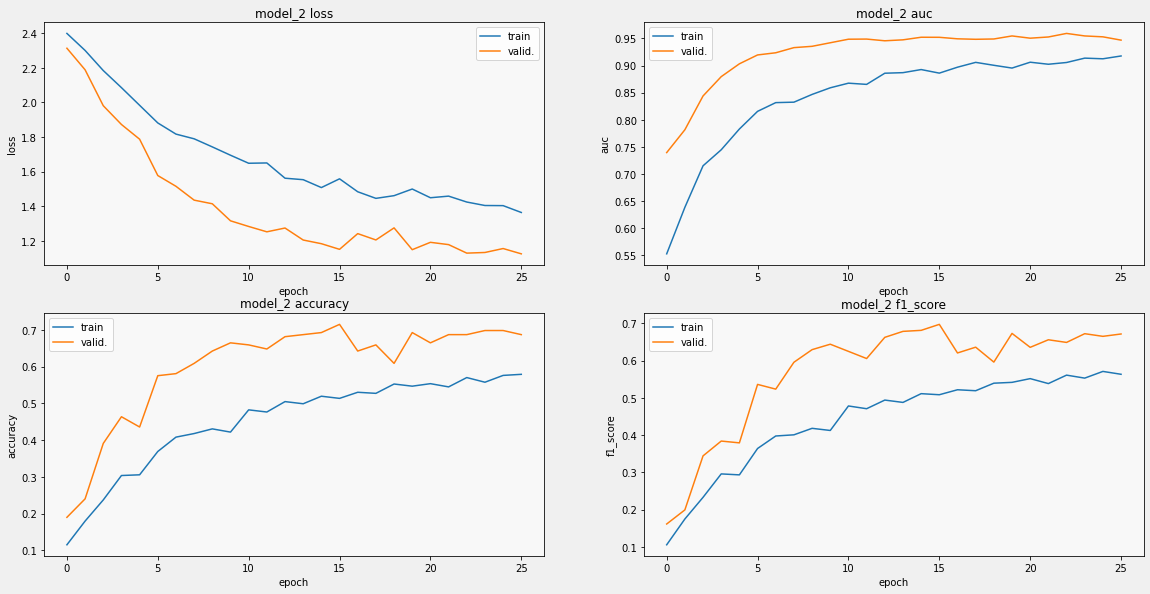

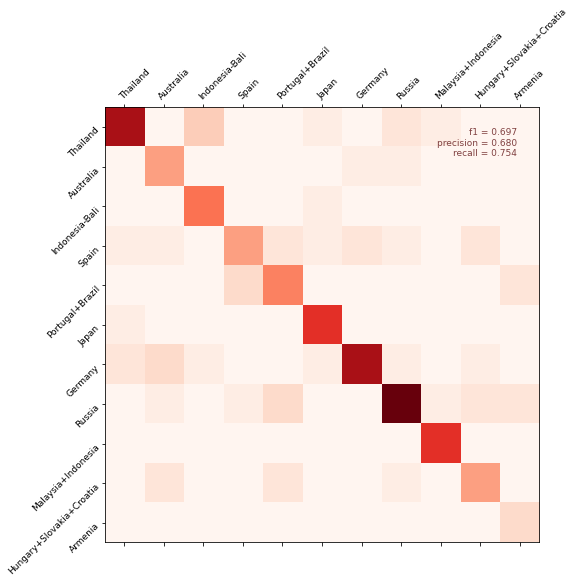

model_2 f1_score: 0.697, precision: 0.680, recall: 0.754
INFO:tensorflow:Assets written to: /tmp/tmpqqil_b8n/assets


INFO:tensorflow:Assets written to: /tmp/tmpqqil_b8n/assets


Model saved to /content/drive/MyDrive/TopTal/models/20210903_134046/model_2.h5  and /content/drive/MyDrive/TopTal/models/20210903_134046/model_2.tflite
Next fold: 3/4
Train set:
Russia                      93
Germany                     80
Thailand                    78
Spain                       51
Japan                       46
Malaysia+Indonesia          42
Portugal+Brazil             41
Hungary+Slovakia+Croatia    36
Indonesia-Bali              34
Australia                   26
Armenia                      9
Name: label_name, dtype: int64
Test set:
Russia                      31
Germany                     27
Thailand                    26
Spain                       17
Japan                       16
Hungary+Slovakia+Croatia    13
Malaysia+Indonesia          13
Portugal+Brazil             13
Indonesia-Bali              11
Australia                    9
Armenia                      2
Name: label_name, dtype: int64
Train set (re-balanced):
Armenia                     93
Germany     

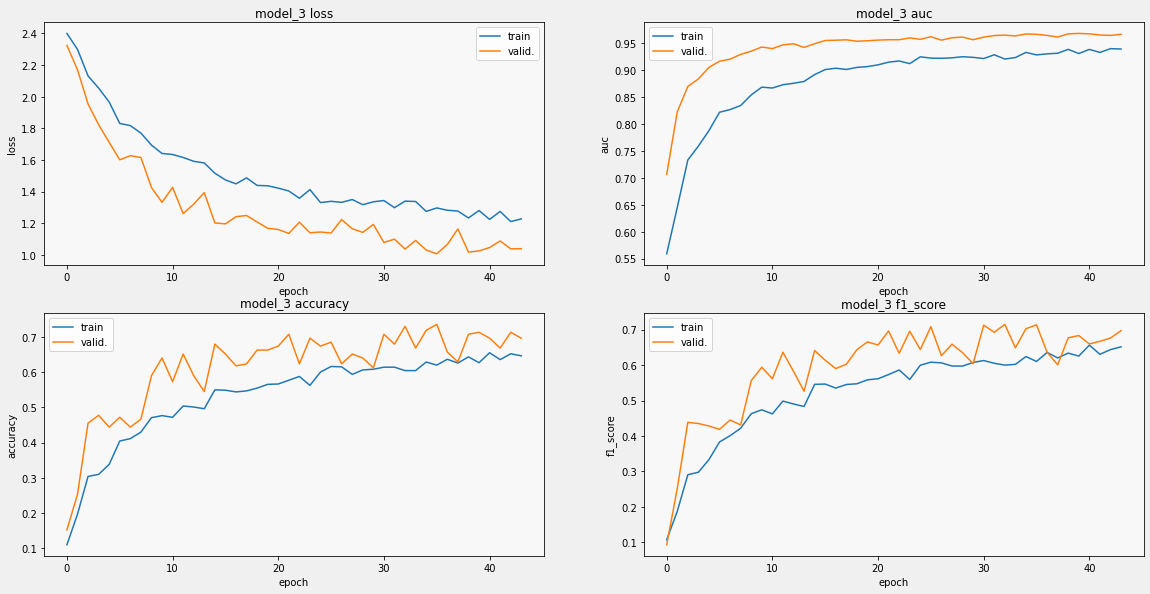

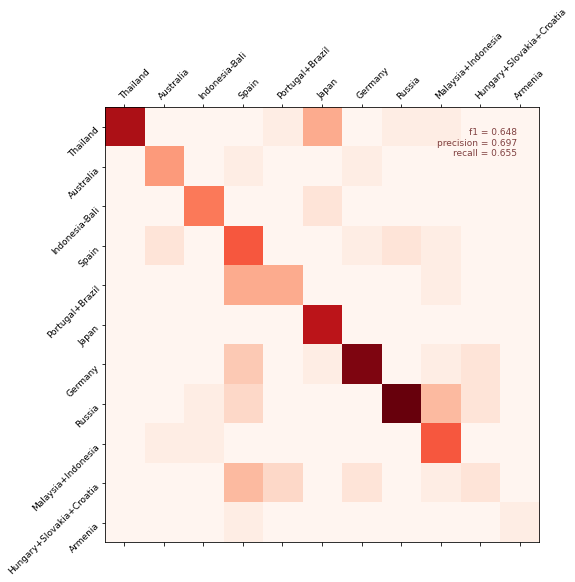

model_3 f1_score: 0.648, precision: 0.697, recall: 0.655
INFO:tensorflow:Assets written to: /tmp/tmplf8gv0lv/assets


INFO:tensorflow:Assets written to: /tmp/tmplf8gv0lv/assets


Model saved to /content/drive/MyDrive/TopTal/models/20210903_134046/model_3.h5  and /content/drive/MyDrive/TopTal/models/20210903_134046/model_3.tflite
Next fold: 4/4
Train set:
Russia                      93
Germany                     81
Thailand                    78
Spain                       51
Japan                       46
Malaysia+Indonesia          41
Portugal+Brazil             41
Hungary+Slovakia+Croatia    37
Indonesia-Bali              33
Australia                   27
Armenia                      8
Name: label_name, dtype: int64
Test set:
Russia                      31
Thailand                    26
Germany                     26
Spain                       17
Japan                       16
Malaysia+Indonesia          14
Portugal+Brazil             13
Indonesia-Bali              12
Hungary+Slovakia+Croatia    12
Australia                    8
Armenia                      3
Name: label_name, dtype: int64
Train set (re-balanced):
Armenia                     93
Germany     

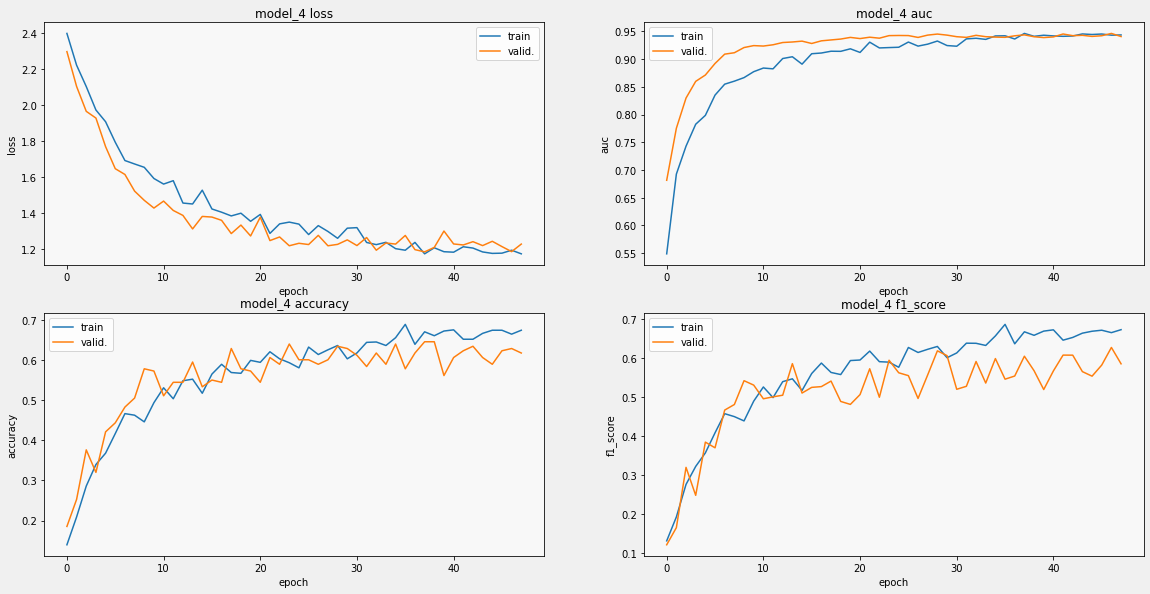

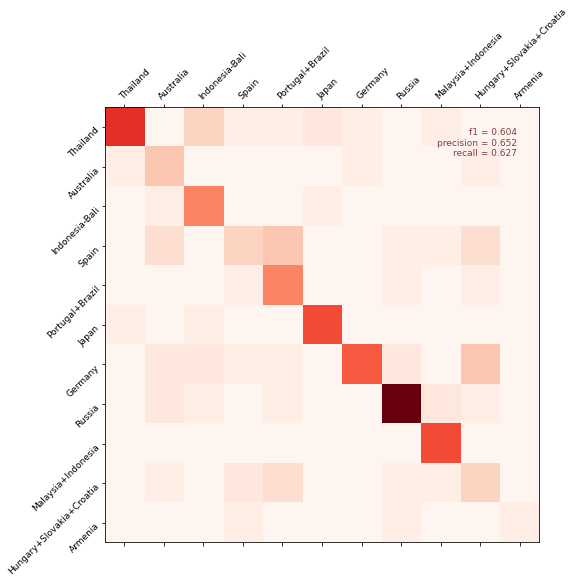

model_4 f1_score: 0.604, precision: 0.652, recall: 0.627
INFO:tensorflow:Assets written to: /tmp/tmpi4dsa8nf/assets


INFO:tensorflow:Assets written to: /tmp/tmpi4dsa8nf/assets


Model saved to /content/drive/MyDrive/TopTal/models/20210903_134046/model_4.h5  and /content/drive/MyDrive/TopTal/models/20210903_134046/model_4.tflite


In [ ]:
# Training models
# 4 Folds (75% / 25%) -> training 4 models
# models are saved as 'model_x.h5'

from datetime import datetime


EPOCHS = 90
BS = 16
FOLDS = 4

MODEL_SUBDIR = datetime.now().strftime("%Y%m%d_%H%M%S")

from sklearn.model_selection import KFold, StratifiedKFold


kf = StratifiedKFold(n_splits=FOLDS)            # important, since we have very unbalanced class distribution
fold = 0
for train_index, test_index in kf.split(imagesDf, imagesDf['label']):
  fold+=1
  print(f"Next fold: {fold}/{FOLDS}")
  dfTrain = imagesDf.iloc[train_index, :]
  dfTest = imagesDf.iloc[test_index, :]

  print("Train set:")
  print(dfTrain['label_name'].value_counts())
  print("Test set:")
  print(dfTest['label_name'].value_counts())

  dfTrain = rebalance_label_distribution(dfTrain)    # we make sure validation set contains no samples from the training set

  print("Train set (re-balanced):")
  print(dfTrain['label_name'].value_counts())

  train_dataset = build_dataset(dfTrain['fileName'], dfTrain['label'], augment=True, bsize=BS)  # cache_dir="data_cache/" # data can be cached on disk
  test_dataset = build_dataset(dfTest['fileName'], dfTest['label'], augment=False, bsize=BS, shuffle=False, repeat=False)  # cache_dir="data_cache/" # data can be cached on disk

  model = generate_model(input_shape=INPUT_SIZE + (3,), num_classes=len(LABELS))

  STEPS_PER_EPOCH = len(dfTrain) / BS

  history = model.fit(train_dataset, 
                      steps_per_epoch = STEPS_PER_EPOCH, 
                      epochs = EPOCHS,
                      validation_data = test_dataset,
                      verbose=1,
                      callbacks = [
                      #    lr_callback, 
                          early_stopping
                      ]
                      )
  
  display_training_curves(history.history['loss'],  history.history['val_loss'], f'model_{fold}', 'loss', 221)
  display_training_curves(history.history['auc'],  history.history['val_auc'] , f'model_{fold}', 'auc', 222)
  display_training_curves(history.history['accuracy'],  history.history['val_accuracy'] , f'model_{fold}', 'accuracy', 223)
  display_training_curves(history.history['f1_score'],  history.history['val_f1_score'] , f'model_{fold}', 'f1_score', 224)
  plt.show()

  validate_model(model, test_dataset, f'model_{fold}')

  save_model(model, f"{MODEL_SAVE_DIR}/{MODEL_SUBDIR}/model_{fold}", with_tf_lite=True)

  


In [ ]:
# get predictions and evaluate all models

next(iter(train_dataset.unbatch()))

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         ...,
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ]],
 
        [[0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         ...,
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ]],
 
        [[0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         ...,
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ],
         [0.9652817 , 0.9581224 , 0.9550186 ]],
 
        ...,
 
        [[0.49505934, 0.4254974 

In [ ]:
class AverageModel():
  def __init__(self, models_path):
    self.models_path = models_path
    self.models=[]
    for i in range(1,5):
      model = tf.keras.models.load_model(f"{models_path}/model_{i}.h5")
      self.models.append(model)

  def predict(self, X):   # X in batches
    probabilities = [model.predict(X) for model in self.models]
    avg_prob = (probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3]) / 4
    return avg_prob



models_path = '/content/drive/MyDrive/TopTal/models/20210903_134046'
avg_model = AverageModel(models_path)

val_dataset = build_dataset(imagesDf['fileName'], imagesDf['label'], augment=False, bsize=32, repeat=False, shuffle=False)

# val_dataset = val_dataset.take(2)
# predictions, avg_prob = avg_model.predict(val_dataset)
# print(predictions)
# print(avg_prob)

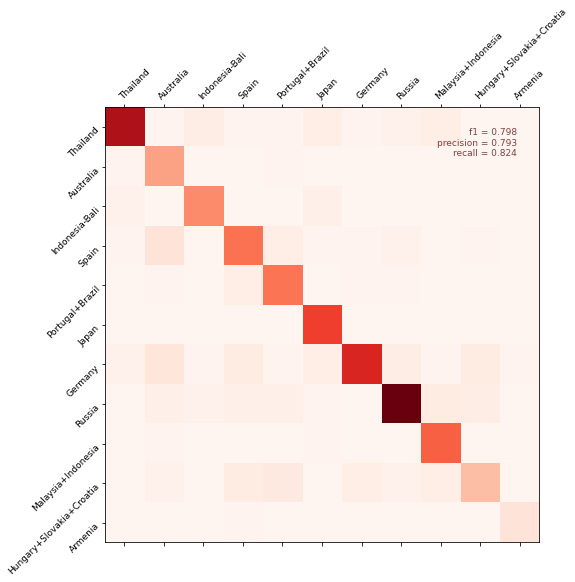

avg_model f1_score: 0.798, precision: 0.793, recall: 0.824


In [ ]:
validate_model(avg_model, val_dataset, f'avg_model')

In [ ]:

def optimize_tflite(models_input_path, models_output_path):
  for i in range(1,5):
      model_to_tflite(f"{models_input_path}/model_{i}.h5", f"{models_output_path}/model_{i}.tflite", with_optimizations=True)
      
  
models_path = '/content/drive/MyDrive/TopTal/models/20210903_134046'
#optimize_tflite(f"{models_path}", f"{models_path}_opt")

INFO:tensorflow:Assets written to: /tmp/tmplh2uupa3/assets


INFO:tensorflow:Assets written to: /tmp/tmplh2uupa3/assets


Model saved to '/content/drive/MyDrive/TopTal/models/20210903_134046/model_1.tflite' 
INFO:tensorflow:Assets written to: /tmp/tmpse7fh2cp/assets


INFO:tensorflow:Assets written to: /tmp/tmpse7fh2cp/assets


Model saved to '/content/drive/MyDrive/TopTal/models/20210903_134046/model_2.tflite' 
INFO:tensorflow:Assets written to: /tmp/tmpdqbfx5fi/assets


INFO:tensorflow:Assets written to: /tmp/tmpdqbfx5fi/assets


Model saved to '/content/drive/MyDrive/TopTal/models/20210903_134046/model_3.tflite' 
INFO:tensorflow:Assets written to: /tmp/tmpovl6rbxs/assets


INFO:tensorflow:Assets written to: /tmp/tmpovl6rbxs/assets


Model saved to '/content/drive/MyDrive/TopTal/models/20210903_134046/model_4.tflite' 
